# Testing VPU & Signal Reconstruction

The aim of this blog post is to test that we can correctly reconstruct a simple signal. And also to better understand the data of each stage.

## Test Binary Vectors
Let's test first by randomly selecting between [0, 0] and [1, 1] vectors.

In [1]:
from src.var_processor.vpu import VPU, VPUBinary
import random
import numpy as np

In [2]:
random.random()

0.46799349226432885

In [3]:
def rand_same():
    a = np.empty([2, 1])
    a.fill(np.random.randint(2))
    return a

In [4]:
def rand_diff():
    a = np.zeros([2, 1])
    index = np.random.randint(2)
    a[index] = 1
    return a

In [5]:
print(rand_same(), rand_same().shape)

[[1.]
 [1.]] (2, 1)


In [6]:
print(rand_diff(), rand_diff().shape)

[[1.]
 [0.]] (2, 1)


In [7]:
vpu = VPU(2)
print(vpu.cu.covariance, vpu.pi.ev)
for _ in range(0, 1000):
    vpu.update_cov(rand_same())
    vpu.pi.iterate(cov=vpu.cu.covariance)
print(vpu.cu.covariance, vpu.pi.ev)

[[0. 0.]
 [0. 0.]] [[0.81341381]
 [0.58168546]]
[[0.24586054 0.24586054]
 [0.24586054 0.24586054]] [[0.70710678]
 [0.70710678]]


In [8]:
print(vpu.pi.eigenvalue, vpu.pi.eigenvector)

[[0.49172109]] [[0.70710678]
 [0.70710678]]


In [9]:
np.sqrt(vpu.pi.eigenvalue)

array([[0.70122827]])

In [10]:
np.dot(vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))

array([[0.49584326],
       [0.49584326]])

Does the above expression thus give you something to do with the probability for the vector?

In [11]:
np.dot(vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))+vpu.cu.mean

array([[0.96384326],
       [0.96384326]])

We can use this to same with x = 1 or 0? Or x = -1, or 1?

In [12]:
print(
    np.dot(vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))+vpu.cu.mean,
    -1*np.dot(vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))+vpu.cu.mean
)

[[0.96384326]
 [0.96384326]] [[-0.02784326]
 [-0.02784326]]


Yes - x = -1 or 1 or random value within this range.

In [26]:
# Adapt to test

vpu = VPU(2)
for _ in range(0, 1000):
    vpu.update_cov(rand_same())
    vpu.pi.iterate(cov=vpu.cu.covariance)
# Check all values of covariance matrix are the same
print(vpu.cu.covariance, vpu.cu.covariance[0])
assert np.allclose(vpu.cu.covariance, vpu.cu.covariance[0])
# Check eigenvector has values of root 2
print(vpu.pi.eigenvector, 1/np.sqrt(2))
assert np.allclose(vpu.pi.eigenvector, 1/np.sqrt(2))
sample_1 = np.dot(
        vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))+vpu.cu.mean
sample_minus1 = -1*np.dot(
        vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))+vpu.cu.mean
assert np.allclose(sample_1, np.array([1, 1]), rtol=0.05, atol=0.05)
assert np.allclose(sample_minus1, np.array([0, 0]), rtol=0.05, atol=0.05)

[[0.24691728 0.24691728]
 [0.24691728 0.24691728]] [0.24691728 0.24691728]
[[0.70710678]
 [0.70710678]] 0.7071067811865475


In [24]:
1/np.sqrt(2)

0.7071067811865475

In [13]:
vpu = VPU(2)
print(vpu.cu.covariance, vpu.pi.ev, sep="\n", end="\n\n")
for _ in range(0, 1000):
    vpu.update_cov(rand_diff())
    vpu.pi.iterate(cov=vpu.cu.covariance)
print(vpu.cu.covariance, vpu.pi.ev, vpu.pi.eigenvalue, sep="\n", end="\n\n")
print(
    vpu.cu.mean,
    np.dot(vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue)), 
    np.dot(vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))+vpu.cu.mean,
    sep="\n",
    end="\n\n"
)

[[0. 0.]
 [0. 0.]]
[[0.79083108]
 [0.61203448]]

[[ 0.24667776 -0.24667776]
 [-0.24667776  0.24667776]]
[[ 0.70710678]
 [-0.70710678]]
[[0.49335551]]

[[0.486]
 [0.514]]
[[ 0.49666665]
 [-0.49666665]]
[[0.98266665]
 [0.01733335]]



How would we get a sample of [0, 1] if x = 0 then we just have mean. Ah - x needs to be between -1 and 1.

In [14]:
# Forward Pass
a = rand_diff()
print(a, np.dot(vpu.pi.eigenvector.T, a))

[[0.]
 [1.]] [[-0.70710678]]


In [15]:
np.dot(vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))+vpu.cu.mean

array([[0.98266665],
       [0.01733335]])

In [16]:
-1*np.dot(vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))+vpu.cu.mean

array([[-0.01066665],
       [ 1.01066665]])

In [34]:
# Adapt to test

vpu = VPU(2)
for _ in range(0, 1000):
    vpu.update_cov(rand_diff())
    vpu.pi.iterate(cov=vpu.cu.covariance)
# Check diagonal values of covariance matrix are the same
# Use https://docs.scipy.org/doc/numpy/reference/generated/numpy.diagonal.html
print(vpu.cu.covariance[0], -1*vpu.cu.covariance[-1])
assert np.allclose(vpu.cu.covariance[0], -1*vpu.cu.covariance[-1])
# Check eigenvector has values of root 2
print(vpu.pi.eigenvector, 1/np.sqrt(2))
assert np.allclose(np.abs(vpu.pi.eigenvector), 1/np.sqrt(2))
# Check different signs
assert np.allclose(vpu.pi.eigenvector[0], -1*vpu.pi.eigenvector[1])
sample_1 = np.dot(
        vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))+vpu.cu.mean
sample_minus1 = -1*np.dot(
        vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))+vpu.cu.mean
print(sample_1, np.flipud(sample_minus1))
assert np.allclose(sample_1, np.flipud(sample_minus1), rtol=0.1, atol=0.1)

[ 0.24607419 -0.24607419] [ 0.24607419 -0.24607419]
[[ 0.70710678]
 [-0.70710678]] 0.7071067811865475
[[ 1.02705866]
 [-0.02705866]] [[0.96505866]
 [0.03494134]]


## Test Reconstruction

So we do a forward pass - get the output r, reconstruct then subtract.

In [35]:
# Setup VPU
vpu = VPU(2)
for _ in range(0, 1000):
    vpu.update_cov(rand_same())
    vpu.pi.iterate(cov=vpu.cu.covariance)

In [40]:
# Test forward pass with no processing
ran = rand_same()
r = vpu.forward(ran)
print(ran, r)

[[1.]
 [1.]] [[1.41421356]]


So [0, 0] r = 0 and for [1, 1] r = 1.414.

In [41]:
vpu.cu.mean

array([[0.509],
       [0.509]])

In [68]:
# Test forward pass with mean removal
ran = rand_same()
r = vpu.forward(ran-vpu.cu.mean)
print(ran, r)

[[0.]
 [0.]] [[-0.7198347]]


Now we have [0, 0] = -0.7198, [1, 1] = 0.69437886.

In [52]:
print(vpu.pi.eigenvector, vpu.pi.eigenvalue)
vpu.pi.eigenvector / np.sqrt(vpu.pi.eigenvalue)

[[0.70710678]
 [0.70710678]] [[0.49364388]]


array([[1.00641736],
       [1.00641736]])

In [59]:
# Test forward pass with mean removal and divide by eigenvalue - SAME
ran = rand_same()
r = vpu.forward((ran-vpu.cu.mean)/np.sqrt(vpu.pi.eigenvalue))
print(ran, r)

[[0.]
 [0.]] [[-1.02453288]]


Now we have outputs between -1 and 1.

In [67]:
# Test forward pass with mean removal and divide by eigenvalue - DIFFERENCES
ran = rand_diff()
r = vpu.forward((ran-vpu.cu.mean)/np.sqrt(vpu.pi.eigenvalue))
print(ran, r)

[[0.]
 [1.]] [[-0.01811551]]


Non-feature outputs are then 0.

In [159]:
vpu.cu.mean

array([[0.509],
       [0.509]])

### Test Signal Reconstruction Over Time

Let's say we have a random 8-bit static signal - [28, 234] - let's experiment with putting this through the system and looking at the output over 255 time steps.

In [115]:
data_in = np.random.randint(255, size=(2, 1)); print(data_in)

[[19]
 [76]]


In [116]:
# Determine signal mean - we'll do a test version
signal_mean = np.random.randint(255, size=(2, 255)).mean(axis=1).reshape(2,1); print(signal_mean)

[[128.99215686]
 [129.31764706]]


In [117]:
# Subtract mean and binary threshold +ve and -ve
zero_mean = data_in - signal_mean; print(zero_mean)

[[-109.99215686]
 [ -53.31764706]]


To cope with the sign we can just - get an array indicating the sign, threshold the absolute, then re-apply the sign.

Use - https://docs.scipy.org/doc/numpy/reference/generated/numpy.sign.html.

But we need to know the range for determining - does this require symmetric ranges either side of the mean? It will be 255-min_mean

In [118]:
signs = np.sign(zero_mean); print(signs)

[[-1.]
 [-1.]]


In [119]:
pbt_range = int(255-signal_mean.min()); print(pbt_range)

126


In [120]:
rand_vals = np.random.randint(pbt_range, size=data_in.shape)
binary_values = np.where(np.abs(zero_mean) > rand_vals, 1, 0)
print(binary_values)

[[1]
 [1]]


In [151]:
# Turn into a short function
def signal_pre_processor(signal, mean):
    """Remove mean and convert to range {-1, 0, 1}"""
    zero_mean = signal - mean
    signs = np.sign(zero_mean)
    rand_vals = np.random.uniform(size=zero_mean.shape)*mean
    binary_values = np.where(np.abs(zero_mean) > rand_vals, 1, 0)
    return binary_values*signs

In [155]:
signal_pre_processor(data_in, signal_mean)

array([[-1.],
       [-0.]])

In [131]:
summed = signal_pre_processor(data_in, signal_mean)
for _ in range(0, int(signal_mean.min())):
    summed += signal_pre_processor(data_in, signal_mean)
print(summed+signal_mean)

[[18.99215686]
 [70.31764706]]


Why are we getting 225 and 80? Something to do with the pbt_range? No - we need to make sure we are summing over the signal mean and then adding the mean.

This can likely be a scalar mean. But if our signals are all different? 

Need to evaluate each element in multiples of the mean value.

We can add this to the sensor routine? DONE

In [135]:
print(255 // signal_mean, 255 % signal_mean, sep="\n")

[[1.]
 [1.]]
[[126.00784314]
 [125.68235294]]


In [136]:
print(3467 // signal_mean, 3467 % signal_mean, sep="\n")

[[26.]
 [26.]]
[[113.20392157]
 [104.74117647]]


In [137]:
summed = signal_pre_processor(data_in, signal_mean)
for _ in range(0, 3467):
    summed += signal_pre_processor(data_in, signal_mean)
print(summed)

[[-3018.]
 [-1495.]]


In [143]:
(summed / (3467 / signal_mean))+signal_mean

array([[16.70535865],
       [73.55477358]])

So we just divide the sum by the (total count / signal mean).

To determine we can generate a random number between 0 and 1 and times by the signal mean.

In [150]:
rand_vals = np.random.uniform(size=zero_mean.shape)*signal_mean
binary_values = np.where(np.abs(zero_mean) > rand_vals, 1, 0)
print(zero_mean, rand_vals, binary_values, sep="\n")

[[-109.99215686]
 [ -53.31764706]]
[[ 66.18549605]
 [125.70555556]]
[[1]
 [0]]


The above is now added to sensor. Anyway back to reconstruction.

# Reconstructing a Static Signal

* So we generate a random data_in vector. 
* Remove the mean and PBT as above. 
* Then provide as upper input to first VPU. 
* Have alpha = 1 and have the residual as the same input. 
* Repeat 1000 times. 
* Then loop output r in a feedback run (1000 times). 
* Get prediction and compute residual. 
* Repeat with another VPU and residual signal. 
* Sum first residual and second residual over time and compare with original random vector.

In [165]:
data_in = np.random.randint(255, size=(2, 1)); print(data_in)

[[ 61]
 [196]]


In [166]:
mean_sum = 0
count = 0
mean_sum += data_in
count += 1
mean = mean_sum/count
ternary_input = signal_pre_processor(data_in, mean); print(mean, ternary_input, sep="\n")

[[ 61.]
 [196.]]
[[0.]
 [0.]]


In [195]:
# Initialise the two VPUs
vpu_1 = VPU(2)
vpu_2 = VPU(2)

Ah we can't compute the mean as we only have a static value! Let's just hard code this as [128, 128]

In [196]:
mean = np.asarray([128, 128]).reshape(-1, 1)

In [201]:
# Loop 
for _ in range(0, 1000):
    ternary_input = signal_pre_processor(data_in, mean)
    vpu.update_cov(ternary_input)
    vpu.pi.iterate(cov=vpu.cu.covariance)
    r = vpu.forward(ternary_input)
    pred = vpu.backward(r) 
    # Check values
    print(
        f"PBT: {ternary_input.T}", 
        f"r: {r}", 
        f"ev: {vpu.pi.eigenvector.T}",
        f"lambda: {vpu.pi.eigenvalue}",
        f"Scaled r: {r/np.sqrt(vpu.pi.eigenvalue)}", 
        f"Rounded r: {np.round(r)}", 
        f"Predictions: {pred.T}", 
        f"Rounded preds: {np.round(pred).T}", 
        sep="\n", end="\n-------\n")

PBT: [[-1  0]]
r: [[-0.96267003]]
ev: [[ 0.96267003 -0.2706777 ]]
lambda: [[0.30303478]]
Scaled r: [[-1.74876404]]
Rounded r: [[-1.]]
Predictions: [[-0.92673358  0.26057331]]
Rounded preds: [[-1.  0.]]
-------
PBT: [[-1  0]]
r: [[-0.96271254]]
ev: [[ 0.96271254 -0.27052644]]
lambda: [[0.30303124]]
Scaled r: [[-1.74885147]]
Rounded r: [[-1.]]
Predictions: [[-0.92681544  0.2604392 ]]
Rounded preds: [[-1.  0.]]
-------
PBT: [[-1  0]]
r: [[-0.96276684]]
ev: [[ 0.96276684 -0.27033314]]
lambda: [[0.30302772]]
Scaled r: [[-1.74896029]]
Rounded r: [[-1.]]
Predictions: [[-0.92691999  0.26026779]]
Rounded preds: [[-1.  0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[ 0.96278716 -0.27026077]]
lambda: [[0.30302288]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 1]]
r: [[-0.27017173]]
ev: [[ 0.96281215 -0.27017173]]
lambda: [[0.3030074]]
Scaled r: [[-0.49080987]]
Rounded r: [[-0.]]
Predictions: [[-0.26012463  0.07299276]]
Rounded preds: [[-0.  0.]]
--

PBT: [[0 0]]
r: [[0.]]
ev: [[ 0.96231516 -0.27193664]]
lambda: [[0.30296248]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[-1  1]]
r: [[-1.23430748]]
ev: [[ 0.96229322 -0.27201425]]
lambda: [[0.30297876]]
Scaled r: [[-2.2424216]]
Rounded r: [[-1.]]
Predictions: [[-1.18776572  0.33574923]]
Rounded preds: [[-1.  0.]]
-------
PBT: [[0 1]]
r: [[-0.27202059]]
ev: [[ 0.96229143 -0.27202059]]
lambda: [[0.30296339]]
Scaled r: [[-0.4942045]]
Rounded r: [[-0.]]
Predictions: [[-0.26176308  0.0739952 ]]
Rounded preds: [[-0.  0.]]
-------
PBT: [[-1  1]]
r: [[-1.23438285]]
ev: [[ 0.96226351 -0.27211934]]
lambda: [[0.30297967]]
Scaled r: [[-2.24255516]]
Rounded r: [[-1.]]
Predictions: [[-1.18780158  0.33589944]]
Rounded preds: [[-1.  0.]]
-------
PBT: [[-1  1]]
r: [[-1.23449565]]
ev: [[ 0.96221902 -0.27227664]]
lambda: [[0.30299595]]
Scaled r: [[-2.24269983]]
Rounded r: [[-1.]]
Predictions: [[-1.18785519  0.33612432]]
Rounded preds: [[-1.  0.]]
---

Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[-1  1]]
r: [[-1.23572297]]
ev: [[ 0.96173237 -0.2739906 ]]
lambda: [[0.30287175]]
Scaled r: [[-2.24538977]]
Rounded r: [[-1.]]
Predictions: [[-1.18843478  0.33857648]]
Rounded preds: [[-1.  0.]]
-------
PBT: [[-1  0]]
r: [[-0.96173651]]
ev: [[ 0.96173651 -0.27397605]]
lambda: [[0.30286801]]
Scaled r: [[-1.74754917]]
Rounded r: [[-1.]]
Predictions: [[-0.92493712  0.26349278]]
Rounded preds: [[-1.  0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[ 0.96172503 -0.27401638]]
lambda: [[0.30286344]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[-0.96174491]]
ev: [[ 0.96174491 -0.27394659]]
lambda: [[0.3028597]]
Scaled r: [[-1.74758838]]
Rounded r: [[-1.]]
Predictions: [[-0.92495327  0.26346673]]
Rounded preds: [[-1.  0.]]
-------
PBT: [[0 1]]
r: [[-0.27385972]]
ev: [[ 0.96176965 -0.27385972]]
lambda: [[0.30284445]]
Scaled r: [[-0.49764352]

Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[ 0.96225869 -0.2721364 ]]
lambda: [[0.30258653]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 1]]
r: [[-0.27216502]]
ev: [[ 0.96225059 -0.27216502]]
lambda: [[0.30257145]]
Scaled r: [[-0.49478706]]
Rounded r: [[-0.]]
Predictions: [[-0.26189095  0.0740738 ]]
Rounded preds: [[-0.  0.]]
-------
PBT: [[-1  0]]
r: [[-0.96227225]]
ev: [[ 0.96227225 -0.27208842]]
lambda: [[0.30256775]]
Scaled r: [[-1.74939001]]
Rounded r: [[-1.]]
Predictions: [[-0.92596789  0.26182314]]
Rounded preds: [[-1.  0.]]
-------
PBT: [[0 1]]
r: [[-0.2719968]]
ev: [[ 0.96229816 -0.2719968 ]]
lambda: [[0.30255268]]
Scaled r: [[-0.49449657]]
Rounded r: [[-0.]]
Predictions: [[-0.26174202  0.07398226]]
Rounded preds: [[-0.  0.]]
-------
PBT: [[-1  1]]
r: [[-1.23431996]]
ev: [[ 0.9622883  -0.27203166]]
lambda: [[0.30256854]]
Scaled r: [[-2.2439639]]
R

PBT: [[-1  1]]
r: [[-1.23435519]]
ev: [[ 0.96227442 -0.27208078]]
lambda: [[0.30238287]]
Scaled r: [[-2.2447168]]
Rounded r: [[-1.]]
Predictions: [[-1.18778842  0.33584432]]
Rounded preds: [[-1.  0.]]
-------
PBT: [[-1  0]]
r: [[-0.96226418]]
ev: [[ 0.96226418 -0.27211699]]
lambda: [[0.30237915]]
Scaled r: [[-1.7499208]]
Rounded r: [[-1.]]
Predictions: [[-0.92595234  0.26184843]]
Rounded preds: [[-1.  0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[ 0.96224364 -0.27218961]]
lambda: [[0.30237476]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[-1  1]]
r: [[-1.23453283]]
ev: [[ 0.96220434 -0.27232848]]
lambda: [[0.30239047]]
Scaled r: [[-2.24501161]]
Rounded r: [[-1.]]
Predictions: [[-1.18787285  0.33619845]]
Rounded preds: [[-1.  0.]]
-------
PBT: [[-1  1]]
r: [[-1.23466263]]
ev: [[ 0.96215308 -0.27250955]]
lambda: [[0.30240619]]
Scaled r: [[-2.24518931]]
Rounded r: [[-1.]]
Predictions: [[-1.18793445  0.33645736]]
Rounded preds: [[-1.  0.]]
-

Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[ 0.96145207 -0.27497256]]
lambda: [[0.30236213]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[ 0.96142116 -0.27508063]]
lambda: [[0.30235786]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[ 0.96138735 -0.27519878]]
lambda: [[0.30235358]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[-1  1]]
r: [[-1.23670512]]
ev: [[ 0.9613396  -0.27536552]]
lambda: [[0.30236925]]
Scaled r: [[-2.24904088]]
Rounded r: [[-1.]]
Predictions: [[-1.18889361  0.34054595]]
Rounded preds: [[-1.  0.]]
-------
PBT: [[-1  1]]
r: [[-1.23684615]]
ev: [[ 0.96128296 -0.27556319]]
lambda: [[0.30238492]]
Scaled r: [[-2.24923906]]
Rounded r: [[-1.]]
Predictions: [[-1.18895913  0.34082928]]
Rounded preds: [[-1.  0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[ 0.96123272

PBT: [[-1  0]]
r: [[-0.96045966]]
ev: [[ 0.96045966 -0.27841918]]
lambda: [[0.30220717]]
Scaled r: [[-1.74713613]]
Rounded r: [[-1.]]
Predictions: [[-0.92248276  0.26741039]]
Rounded preds: [[-1.  0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[ 0.96045269 -0.27844324]]
lambda: [[0.30220304]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 1]]
r: [[-0.27841682]]
ev: [[ 0.96046034 -0.27841682]]
lambda: [[0.3021882]]
Scaled r: [[-0.50647349]]
Rounded r: [[-0.]]
Predictions: [[-0.26740832  0.07751593]]
Rounded preds: [[-0.  0.]]
-------
PBT: [[-1  0]]
r: [[-0.96049207]]
ev: [[ 0.96049207 -0.27830735]]
lambda: [[0.30218424]]
Scaled r: [[-1.74726138]]
Rounded r: [[-1.]]
Predictions: [[-0.92254502  0.267312  ]]
Rounded preds: [[-1.  0.]]
-------
PBT: [[0 1]]
r: [[-0.27819565]]
ev: [[ 0.96052443 -0.27819565]]
lambda: [[0.30216942]]
Scaled r: [[-0.50608687]]
Rounded r: [[-0.]]
Predictions: [[-0.26721371  0.07739282]]
Rounded preds: [[-0.  0.]]
----

PBT: [[-1  1]]
r: [[-1.23852212]]
ev: [[ 0.96060508 -0.27791703]]
lambda: [[0.30203833]]
Scaled r: [[-2.25357874]]
Rounded r: [[-1.]]
Predictions: [[-1.18973064  0.34420639]]
Rounded preds: [[-1.  0.]]
-------
PBT: [[-1  0]]
r: [[-0.96059788]]
ev: [[ 0.96059788 -0.27794191]]
lambda: [[0.30203437]]
Scaled r: [[-1.74788735]]
Rounded r: [[-1.]]
Predictions: [[-0.92274829  0.26699041]]
Rounded preds: [[-1.  0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[ 0.96057917 -0.27800656]]
lambda: [[0.30203029]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[-1  1]]
r: [[-1.23867888]]
ev: [[ 0.96054122 -0.27813766]]
lambda: [[0.30204576]]
Scaled r: [[-2.25383626]]
Rounded r: [[-1.]]
Predictions: [[-1.18980213  0.34452324]]
Rounded preds: [[-1.  0.]]
-------
PBT: [[0 1]]
r: [[-0.27817966]]
ev: [[ 0.96052906 -0.27817966]]
lambda: [[0.30203103]]
Scaled r: [[-0.50617372]]
Rounded r: [[-0.]]
Predictions: [[-0.26719965  0.07738393]]
Rounded preds: [[-0.  0.]]
-

r: [[-0.96128898]]
ev: [[ 0.96128898 -0.2755422 ]]
lambda: [[0.3015987]]
Scaled r: [[-1.75040775]]
Rounded r: [[-1.]]
Predictions: [[-0.9240765   0.26487568]]
Rounded preds: [[-1.  0.]]
-------
PBT: [[-1  0]]
r: [[-0.961344]]
ev: [[ 0.961344   -0.27535016]]
lambda: [[0.30159485]]
Scaled r: [[-1.75051911]]
Rounded r: [[-1.]]
Predictions: [[-0.92418229  0.26470622]]
Rounded preds: [[-1.  0.]]
-------
PBT: [[-1  0]]
r: [[-0.96140565]]
ev: [[ 0.96140565 -0.27513485]]
lambda: [[0.30159101]]
Scaled r: [[-1.75064251]]
Rounded r: [[-1.]]
Predictions: [[-0.92430082  0.26451619]]
Rounded preds: [[-1.  0.]]
-------
PBT: [[-1  1]]
r: [[-1.23650582]]
ev: [[ 0.96141954 -0.27508628]]
lambda: [[0.30160626]]
Scaled r: [[-2.25152093]]
Rounded r: [[-1.]]
Predictions: [[-1.18880086  0.34014579]]
Rounded preds: [[-1.  0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[ 0.96141448 -0.27510397]]
lambda: [[0.30160222]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 

r: [[0.]]
ev: [[ 0.96209442 -0.27271655]]
lambda: [[0.30140063]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 1]]
r: [[-0.2726373]]
ev: [[ 0.96211689 -0.2726373 ]]
lambda: [[0.30138625]]
Scaled r: [[-0.49661925]]
Rounded r: [[-0.]]
Predictions: [[-0.26230895  0.0743311 ]]
Rounded preds: [[-0.  0.]]
-------
PBT: [[-1  0]]
r: [[-0.96215723]]
ev: [[ 0.96215723 -0.27249487]]
lambda: [[0.30138245]]
Scaled r: [[-1.7526172]]
Rounded r: [[-1.]]
Predictions: [[-0.92574654  0.26218291]]
Rounded preds: [[-1.  0.]]
-------
PBT: [[0 1]]
r: [[-0.27236054]]
ev: [[ 0.96219527 -0.27236054]]
lambda: [[0.30136809]]
Scaled r: [[-0.49613007]]
Rounded r: [[-0.]]
Predictions: [[-0.26206402  0.07418026]]
Rounded preds: [[-0.  0.]]
-------
PBT: [[-1  0]]
r: [[-0.96224562]]
ev: [[ 0.96224562 -0.27218258]]
lambda: [[0.3013643]]
Scaled r: [[-1.75283099]]
Rounded r: [[-1.]]
Predictions: [[-0.92591664  0.2619065 ]]
Rounded preds: [[-1.  0.]]
-------
PBT: [[-1  

In [202]:
def non_linearity(array):
    """Apply a non-linearity to array."""
    signs = np.sign(array)
    rand_vals = np.random.uniform(size=array.shape)
    binary_values = np.where(np.abs(array) > rand_vals, 1, 0)
    return binary_values*signs

In [203]:
# Loop
sum_preds = 0
sum_inputs = 0
for _ in range(0, 1000):
    ternary_input = signal_pre_processor(data_in, mean)
    sum_inputs += ternary_input
    vpu.update_cov(ternary_input)
    vpu.pi.iterate(cov=vpu.cu.covariance)
    r = vpu.forward(ternary_input)
    pred = vpu.backward(r) 
    sum_preds += pred
    # Check values
    print(
        f"PBT: {ternary_input.T}", 
        f"r: {r}", 
        f"ev: {vpu.pi.eigenvector.T}",
        f"lambda: {vpu.pi.eigenvalue}",
        f"Scaled r: {r*np.sqrt(vpu.pi.eigenvalue)}", 
        f"NL r: {non_linearity(r)}", 
        f"Predictions: {pred.T}", 
        f"NL preds: {non_linearity(pred).T}", 
        sep="\n", end="\n-------\n")

PBT: [[-1  0]]
r: [[-0.96213033]]
ev: [[ 0.96213033 -0.27258985]]
lambda: [[0.30138808]]
Scaled r: [[-0.52819823]]
NL r: [[-1.]]
Predictions: [[-0.92569477  0.26226696]]
NL preds: [[-1.  0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[ 0.96211145 -0.27265648]]
lambda: [[0.30138412]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[ 0.96208541 -0.27274835]]
lambda: [[0.30138016]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[-0.9620945]]
ev: [[ 0.9620945  -0.27271628]]
lambda: [[0.30137635]]
Scaled r: [[-0.52816828]]
NL r: [[-1.]]
Predictions: [[-0.92562583  0.26237883]]
NL preds: [[-1.  0.]]
-------
PBT: [[-1  1]]
r: [[-1.23485997]]
ev: [[ 0.96207504 -0.27278493]]
lambda: [[0.30139127]]
Scaled r: [[-0.67792719]]
NL r: [[-1.]]
Predictions: [[-1.18802796  0.3368512 ]]
NL preds: [[-1.  0.]]
-------
PBT: [[-1  1]]
r: [[-1.23495562]]
ev: [[ 0.96203717 -0.27291845]]
lambda: [[0.30140

PBT: [[-1  1]]
r: [[-1.23412752]]
ev: [[ 0.96236409 -0.27176343]]
lambda: [[0.3011693]]
Scaled r: [[-0.67727554]]
NL r: [[-1.]]
Predictions: [[-1.18768001  0.33539073]]
NL preds: [[-1.  1.]]
-------
PBT: [[0 1]]
r: [[-0.27178913]]
ev: [[ 0.96235683 -0.27178913]]
lambda: [[0.30115508]]
Scaled r: [[-0.14915135]]
NL r: [[-0.]]
Predictions: [[-0.26155813  0.07386933]]
NL preds: [[-0.  0.]]
-------
PBT: [[-1  1]]
r: [[-1.23422161]]
ev: [[ 0.96232705 -0.27189457]]
lambda: [[0.30116982]]
Scaled r: [[-0.67732775]]
NL r: [[-1.]]
Predictions: [[-1.18772484  0.33557815]]
NL preds: [[-1.  0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[ 0.96229399 -0.27201154]]
lambda: [[0.30116594]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[ 0.96225882 -0.27213594]]
lambda: [[0.30116206]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[-1  1]]
r: [[-1.23451601]]
ev: [[ 0.96221098 -0.27230502]]
lambda: [[0.3011768

PBT: [[-1  1]]
r: [[-1.23546809]]
ev: [[ 0.96183381 -0.27363428]]
lambda: [[0.30097564]]
Scaled r: [[-0.6777932]]
NL r: [[-1.]]
Predictions: [[-1.18831498  0.33806642]]
NL preds: [[-1.  0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[ 0.96181319 -0.27370675]]
lambda: [[0.30097186]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[-0.96182548]]
ev: [[ 0.96182548 -0.27366355]]
lambda: [[0.30096799]]
Scaled r: [[-0.52766275]]
NL r: [[-1.]]
Predictions: [[-0.92510826  0.26321658]]
NL preds: [[-1.  0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[ 0.96181959 -0.27368427]]
lambda: [[0.30096421]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[-1  1]]
r: [[-1.23557633]]
ev: [[ 0.96179076 -0.27378557]]
lambda: [[0.30097887]]
Scaled r: [[-0.67785621]]
NL r: [[-1.]]
Predictions: [[-1.18836589  0.33828297]]
NL preds: [[-1.  1.]]
-------
PBT: [[0 1]]
r: [[-0.27380884]]
ev: [[ 0.96178413 -0.27380884]]
lambda: [[0.3009647

PBT: [[0 1]]
r: [[-0.27264081]]
ev: [[ 0.96211589 -0.27264081]]
lambda: [[0.30085559]]
Scaled r: [[-0.14954432]]
NL r: [[-0.]]
Predictions: [[-0.26231206  0.07433301]]
NL preds: [[-0.  0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[ 0.96210641 -0.27267426]]
lambda: [[0.30085186]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[-0.96212568]]
ev: [[ 0.96212568 -0.27260628]]
lambda: [[0.300848]]
Scaled r: [[-0.52772221]]
NL r: [[-1.]]
Predictions: [[-0.92568582  0.2622815 ]]
NL preds: [[-1.  1.]]
-------
PBT: [[-1  1]]
r: [[-1.23476314]]
ev: [[ 0.96211335 -0.27264979]]
lambda: [[0.30086248]]
Scaled r: [[-0.6772791]]
NL r: [[-1.]]
Predictions: [[-1.1879821   0.33665791]]
NL preds: [[-1.  0.]]
-------
PBT: [[-1  1]]
r: [[-1.23484607]]
ev: [[ 0.96208054 -0.27276553]]
lambda: [[0.30087696]]
Scaled r: [[-0.67734089]]
NL r: [[-1.]]
Predictions: [[-1.18802137  0.33682344]]
NL preds: [[-1.  1.]]
-------
PBT: [[0 1]]
r: [[-0.2727981]]
ev: [[ 0.962071

PBT: [[-1  1]]
r: [[-1.23480903]]
ev: [[ 0.96209519 -0.27271384]]
lambda: [[0.30066463]]
Scaled r: [[-0.67708153]]
NL r: [[-1.]]
Predictions: [[-1.18800384  0.33674951]]
NL preds: [[-1.  0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[ 0.96205041 -0.27287177]]
lambda: [[0.30066098]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[ 0.96200755 -0.27302285]]
lambda: [[0.30065734]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 1]]
r: [[-0.27307862]]
ev: [[ 0.96199172 -0.27307862]]
lambda: [[0.30064341]]
Scaled r: [[-0.14973163]]
NL r: [[-0.]]
Predictions: [[-0.26269937  0.07457193]]
NL preds: [[-1.  0.]]
-------
PBT: [[0 1]]
r: [[-0.27307254]]
ev: [[ 0.96199345 -0.27307254]]
lambda: [[0.30062949]]
Scaled r: [[-0.14972482]]
NL r: [[-0.]]
Predictions: [[-0.26269399  0.07456861]]
NL preds: [[-0.  0.]]
-------
PBT: [[0 1]]
r: [[-0.27302629]]
ev: [[ 0.96200657 -0.27302629]]
lambda: [[0.30061556]]

PBT: [[0 1]]
r: [[-0.27619629]]
ev: [[ 0.96110125 -0.27619629]]
lambda: [[0.30060992]]
Scaled r: [[-0.15143264]]
NL r: [[-0.]]
Predictions: [[-0.2654526   0.07628439]]
NL preds: [[-0.  0.]]
-------
PBT: [[-1  1]]
r: [[-1.23735209]]
ev: [[ 0.96107924 -0.27627285]]
lambda: [[0.30062427]]
Scaled r: [[-0.67843043]]
NL r: [[-1.]]
Predictions: [[-1.18919341  0.34184679]]
NL preds: [[-1.  0.]]
-------
PBT: [[-1  1]]
r: [[-1.23744867]]
ev: [[ 0.96104027 -0.27640841]]
lambda: [[0.30063862]]
Scaled r: [[-0.67849957]]
NL r: [[-1.]]
Predictions: [[-1.189238    0.34204122]]
NL preds: [[-1.  0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[ 0.96100108 -0.27654462]]
lambda: [[0.30063509]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[-0.96100108]]
ev: [[ 0.96100108 -0.27654463]]
lambda: [[0.30063108]]
Scaled r: [[-0.52691531]]
NL r: [[-1.]]
Predictions: [[-0.92352307  0.26575968]]
NL preds: [[-1.  0.]]
-------
PBT: [[-1  1]]
r: [[-1.23760682]]
ev: [[ 0.

PBT: [[-1  0]]
r: [[-0.96153591]]
ev: [[ 0.96153591 -0.27467924]]
lambda: [[0.30046199]]
Scaled r: [[-0.52706027]]
NL r: [[-1.]]
Predictions: [[-0.92455131  0.26411396]]
NL preds: [[-1.  0.]]
-------
PBT: [[-1  1]]
r: [[-1.23623519]]
ev: [[ 0.9615279  -0.27470729]]
lambda: [[0.3004761]]
Scaled r: [[-0.67765098]]
NL r: [[-1.]]
Predictions: [[-1.18867463  0.33960282]]
NL preds: [[-1.  1.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[ 0.96150887 -0.2747739 ]]
lambda: [[0.30047264]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[-1  1]]
r: [[-1.2363747]]
ev: [[ 0.96147207 -0.27490262]]
lambda: [[0.30048675]]
Scaled r: [[-0.67773946]]
NL r: [[-1.]]
Predictions: [[-1.18873974  0.33988265]]
NL preds: [[-1.  0.]]
-------
PBT: [[-1  0]]
r: [[-0.96147326]]
ev: [[ 0.96147326 -0.27489848]]
lambda: [[0.30048275]]
Scaled r: [[-0.52704413]]
NL r: [[-1.]]
Predictions: [[-0.92443083  0.26430754]]
NL preds: [[-1.  1.]]
-------
PBT: [[0 1]]
r: [[-0.27485375]]
ev: [[ 0.96

PBT: [[-1  1]]
r: [[-1.23665493]]
ev: [[ 0.96135974 -0.27529519]]
lambda: [[0.30039488]]
Scaled r: [[-0.67778944]]
NL r: [[-1.]]
Predictions: [[-1.18887027  0.34044515]]
NL preds: [[-1.  1.]]
-------
PBT: [[0 1]]
r: [[-0.27533428]]
ev: [[ 0.96134855 -0.27533428]]
lambda: [[0.30038119]]
Scaled r: [[-0.15090257]]
NL r: [[-0.]]
Predictions: [[-0.26469221  0.07580896]]
NL preds: [[-0.  0.]]
-------
PBT: [[0 1]]
r: [[-0.2753178]]
ev: [[ 0.96135327 -0.2753178 ]]
lambda: [[0.3003675]]
Scaled r: [[-0.1508901]]
NL r: [[-1.]]
Predictions: [[-0.26467766  0.07579989]]
NL preds: [[-0.  0.]]
-------
PBT: [[0 1]]
r: [[-0.27526512]]
ev: [[ 0.96136836 -0.27526512]]
lambda: [[0.30035382]]
Scaled r: [[-0.1508578]]
NL r: [[-0.]]
Predictions: [[-0.26463117  0.07577089]]
NL preds: [[-0.  0.]]
-------
PBT: [[0 1]]
r: [[-0.27518884]]
ev: [[ 0.96139019 -0.27518884]]
lambda: [[0.30034013]]
Scaled r: [[-0.15081256]]
NL r: [[-0.]]
Predictions: [[-0.26456386  0.0757289 ]]
NL preds: [[-0.  0.]]
-------
PBT: [[-1  1

NL r: [[-1.]]
Predictions: [[-1.19032176  0.3468469 ]]
NL preds: [[-1.  0.]]
-------
PBT: [[0 1]]
r: [[-0.27972193]]
ev: [[ 0.96008106 -0.27972193]]
lambda: [[0.30026132]]
Scaled r: [[-0.15327673]]
NL r: [[-0.]]
Predictions: [[-0.26855573  0.07824436]]
NL preds: [[-0.  0.]]
-------
PBT: [[-1  0]]
r: [[-0.96011249]]
ev: [[ 0.96011249 -0.27961403]]
lambda: [[0.30025715]]
Scaled r: [[-0.5261006]]
NL r: [[-1.]]
Predictions: [[-0.92181599  0.26846093]]
NL preds: [[-1.  1.]]
-------
PBT: [[-1  1]]
r: [[-1.23973578]]
ev: [[ 0.96010868 -0.2796271 ]]
lambda: [[0.30027115]]
Scaled r: [[-0.67933805]]
NL r: [[-1.]]
Predictions: [[-1.19028109  0.34666372]]
NL preds: [[-1.  1.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[ 0.96009224 -0.27968356]]
lambda: [[0.3002679]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 1]]
r: [[-0.27967911]]
ev: [[ 0.96009353 -0.27967911]]
lambda: [[0.30025426]]
Scaled r: [[-0.15325146]]
NL r: [[-0.]]
Predictions: [[-0.26851811  0.078

PBT: [[-1  1]]
r: [[-1.24165856]]
ev: [[ 0.95931267 -0.28234588]]
lambda: [[0.30023187]]
Scaled r: [[-0.68034717]]
NL r: [[-1.]]
Predictions: [[-1.19113879  0.35057718]]
NL preds: [[-1.  0.]]
-------
PBT: [[0 1]]
r: [[-0.2823474]]
ev: [[ 0.95931223 -0.2823474 ]]
lambda: [[0.30021831]]
Scaled r: [[-0.1547043]]
NL r: [[-1.]]
Predictions: [[-0.27085931  0.07972005]]
NL preds: [[-1.  0.]]
-------
PBT: [[-1  1]]
r: [[-1.24171839]]
ev: [[ 0.95928771 -0.28243067]]
lambda: [[0.30023221]]
Scaled r: [[-0.68038034]]
NL r: [[-1.]]
Predictions: [[-1.19116519  0.35069936]]
NL preds: [[-1.  0.]]
-------
PBT: [[0 1]]
r: [[-0.28244409]]
ev: [[ 0.95928376 -0.28244409]]
lambda: [[0.30021865]]
Scaled r: [[-0.15475737]]
NL r: [[-0.]]
Predictions: [[-0.27094403  0.07977467]]
NL preds: [[-0.  0.]]
-------
PBT: [[-1  0]]
r: [[-0.95930642]]
ev: [[ 0.95930642 -0.28236713]]
lambda: [[0.30021437]]
Scaled r: [[-0.52562146]]
NL r: [[-1.]]
Predictions: [[-0.92026881  0.2708766 ]]
NL preds: [[-1.  0.]]
-------
PBT: [

Is it here just learing to replicate the top entry?

No - our prediction is 0.2 - meaning we have a 1 20% of the time.
* Do we need to scale the R value using the eigenvalue?
* Do we need to scale the predicted outputs using the eigenvalue?
* Do we need to apply the probabilistic computation on the output?

Rounding is not useful - ignore - we need probabilities. Predictions here appear like probabilities - 0.23 means that 1 occurs 23% of the time - -0.23 indicates -1 occurs with 23%.

Some of the predictions are > 1 or -1 - e.g. -1.18307985. r is also sometimes > 1 or -1, e.g. -1.22. This happens when we have [-1, 1]

In [208]:
input_estimate = (sum_inputs / (1000 / mean))+mean
pred_estimate = (sum_preds / (1000 / mean))+mean
residual = input_estimate - pred_estimate
print(f"Input estimate = {input_estimate.T};\nPredicted estimate = {pred_estimate.T};\nresidual = {residual.T}\n")

Input estimate = [[ 61.824 198.144]];
Predicted estimate = [[ 48.26758964 150.87170251]];
residual = [[13.55641036 47.27229749]]



This makes sense - the VPU was better at detecting the first entry than the second.

In [336]:
def add_to_array(array, frame):
    """Add a frame to a rolling array."""
    array = np.roll(array, -1, axis=1)
    # Add frame to end of buffer
    array[..., -1] = frame.flatten()
    return array

class test_vpu_wrapper:
    """Test wrapper for VPU.
    
    Proto - stage/stack. We store 1000 samples in the buffer.
    """
    def __init__(self, vpu, buf_length=1000):
        self.vpu = vpu
        # Temp fields for output
        self.input_buffer = np.zeros(shape=(vpu.size, buf_length))
        self.pred_buffer = np.zeros(shape=(vpu.size, buf_length))
        self.nl_pred_buffer = np.zeros(shape=(vpu.size, buf_length))
        self.r_buffer = np.zeros(shape=(1, buf_length))
        self.residual_buffer = np.zeros(shape=(vpu.size, buf_length))
    
    def iterate(self, input_signal):
        # Update covariance data of VPU
        self.vpu.update_cov(input_signal)
        # Get current covariance matrix
        cov = self.vpu.cu.covariance
        # Power iterate using covariance matrix
        self.vpu.pi.iterate(cov=cov)
        # Get r
        r = self.vpu.forward(input_signal)
        pred = self.vpu.backward(r)
        pred_nl = non_linearity(pred).astype(np.int8)
        
        # Calculate residual
        residual = input_signal.astype(np.int8) - pred_nl
        
        # Store last input and pred for output repr
        # Create rolling sum of inputs
        self.input_buffer = add_to_array(self.input_buffer, input_signal)
        # Add to rolling sum of predictions
        self.pred_buffer = add_to_array(self.pred_buffer, pred)
        self.nl_pred_buffer = add_to_array(self.nl_pred_buffer, pred_nl)
        self.r_buffer = add_to_array(self.r_buffer, r)
        self.residual_buffer =  add_to_array(self.residual_buffer, residual)
        return r, pred, residual
    
    @property
    def input_estimate(self):
        # How do we get the mean in here?
        return (self.input_buffer.sum(axis=1).T / 1000).reshape(-1, 1)
    
    @property
    def pred_estimate(self):
        # How do we get the mean in here?
        return (self.pred_buffer.sum(axis=1).T / 1000).reshape(-1, 1)
    
    @property
    def error(self):
        return self.input_estimate - self.pred_estimate
    
    def __repr__(self):
        return f"""
                Input: {self.input_buffer[:,-1].T}
                r: {self.r_buffer[:,-1]}
                ev: {self.vpu.pi.eigenvector.T}
                lambda: {self.vpu.pi.eigenvalue}
                Scaled r: {self.r_buffer[:,-1]*np.sqrt(self.vpu.pi.eigenvalue)}
                NL r: {non_linearity(self.r_buffer[:,-1])}
                Predictions: {self.pred_buffer[:,-1].T}
                NL Predictions: {self.nl_pred_buffer[:,-1].T}
                Residual: {self.residual_buffer[:,-1].T}
                ------------------------------
        """

In [337]:
wrapper_1 = test_vpu_wrapper(vpu_1)
wrapper_2 = test_vpu_wrapper(vpu_2)

In [371]:
for _ in range(0, 1000):
    # First VPU
    ternary_input = signal_pre_processor(data_in, mean)
    r, pred, residual = wrapper_1.iterate(ternary_input)
    # print(residual)
    # print(ternary_input, pred, ternary_input-pred)
    print(f"Wrapper - 1 {wrapper_1}")
    r, pred, residual = wrapper_2.iterate(residual)
    print(f"Wrapper - 2 {wrapper_2}")

Wrapper - 1 
                Input: [-1.  0.]
                r: [0.74138513]
                ev: [[-0.74138513  0.67107979]]
                lambda: [[0.25105156]]
                Scaled r: [[0.37147136]]
                NL r: [0.]
                Predictions: [-0.54965191  0.49752858]
                NL Predictions: [0. 1.]
                Residual: [-1. -1.]
                ------------------------------
        
Wrapper - 2 
                Input: [-1. -1.]
                r: [-1.41418054]
                ev: [[0.70225809 0.71192245]]
                lambda: [[24.69636584]]
                Scaled r: [[-7.02783217]]
                NL r: [-1.]
                Predictions: [-0.99311972 -1.00678688]
                NL Predictions: [-1. -1.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [-1.  1.]
                r: [1.41246624]
                ev: [[-0.74137253  0.67109372]]
                lambda: [[0.2510

Wrapper - 1 
                Input: [-1.  0.]
                r: [0.7412303]
                ev: [[-0.7412303   0.67125081]]
                lambda: [[0.25114051]]
                Scaled r: [[0.37145957]]
                NL r: [0.]
                Predictions: [-0.54942236  0.49755144]
                NL Predictions: [0. 1.]
                Residual: [-1. -1.]
                ------------------------------
        
Wrapper - 2 
                Input: [-1. -1.]
                r: [-1.41417986]
                ev: [[0.70220836 0.7119715 ]]
                lambda: [[24.64779418]]
                Scaled r: [[-7.0209144]]
                NL r: [-1.]
                Predictions: [-0.99304892 -1.00685576]
                NL Predictions: [-1. -1.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 1.]
                r: [0.67127391]
                ev: [[-0.74120938  0.67127391]]
                lambda: [[0.25113177

Wrapper - 2 
                Input: [1. 1.]
                r: [1.41417911]
                ev: [[0.70215377 0.71202534]]
                lambda: [[24.60224343]]
                Scaled r: [[7.01442011]]
                NL r: [1.]
                Predictions: [0.9929712  1.00693135]
                NL Predictions: [1. 1.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.74072765  0.67180544]]
                lambda: [[0.25111807]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.70215302 0.71202608]]
                lambda: [[24.60146914]]
                Scaled r: [[0.]]
                NL

Wrapper - 1 
                Input: [-1.  1.]
                r: [1.41260655]
                ev: [[-0.74000318  0.67260337]]
                lambda: [[0.25112262]]
                Scaled r: [[0.70788732]]
                NL r: [1.]
                Predictions: [-1.04533334  0.95012392]
                NL Predictions: [-1.  1.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.70210395 0.71207446]]
                lambda: [[24.55336994]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 1.]
                r: [0.67260637]
                ev: [[-0.74000045  0.67260637]]
                lambda: [[0.25111391]]
                Scaled r: [[0.337051

Wrapper - 1 
                Input: [0. 1.]
                r: [0.67334439]
                ev: [[-0.73932897  0.67334439]]
                lambda: [[0.25124558]]
                Scaled r: [[0.33750986]]
                NL r: [1.]
                Predictions: [-0.49782302  0.45339267]
                NL Predictions: [-1.  0.]
                Residual: [1. 1.]
                ------------------------------
        
Wrapper - 2 
                Input: [1. 1.]
                r: [1.41417783]
                ev: [[0.70206236 0.71211547]]
                lambda: [[24.50410664]]
                Scaled r: [[7.00040976]]
                NL r: [1.]
                Predictions: [0.99284102 1.00705791]
                NL Predictions: [1. 1.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.73929697  0.67337953]]
                lambda: [[0.25125644]]
              

Wrapper - 1 
                Input: [-1.  0.]
                r: [0.73913858]
                ev: [[-0.73913858  0.67355338]]
                lambda: [[0.25121965]]
                Scaled r: [[0.37046969]]
                NL r: [1.]
                Predictions: [-0.54632584  0.49784929]
                NL Predictions: [-1.  1.]
                Residual: [ 0. -1.]
                ------------------------------
        
Wrapper - 2 
                Input: [ 0. -1.]
                r: [-0.71215784]
                ev: [[0.70201938 0.71215784]]
                lambda: [[24.45843523]]
                Scaled r: [[-3.52201008]]
                NL r: [-1.]
                Predictions: [-0.49994861 -0.50716879]
                NL Predictions: [0. 0.]
                Residual: [ 0. -1.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.73914679  0.67354437]]
                lambda: [[0.2512305]]
  

Wrapper - 2 
                Input: [-1. -1.]
                r: [-1.4141766]
                ev: [[0.70197586 0.71220074]]
                lambda: [[24.41098006]]
                Scaled r: [[-6.98708866]]
                NL r: [-1.]
                Predictions: [-0.99271783 -1.00717762]
                NL Predictions: [-1. -1.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.73815982  0.67462588]]
                lambda: [[0.25125852]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.70197511 0.71220148]]
                lambda: [[24.41021765]]
                Scaled r: [[0.]]
          

Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.70193661 0.71223942]]
                lambda: [[24.3686699]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.73875713  0.67397174]]
                lambda: [[0.2512248]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.70193587 0.71224015]]
                lambda: [[24.36791012]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictio

Wrapper - 1 
                Input: [-1.  0.]
                r: [0.73989423]
                ev: [[-0.73989423  0.67272322]]
                lambda: [[0.25120362]]
                Scaled r: [[0.37083659]]
                NL r: [1.]
                Predictions: [-0.54744347  0.49774403]
                NL Predictions: [-1.  0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.70189445 0.71228097]]
                lambda: [[24.32048993]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [-1.  0.]
                r: [0.7398786]
                ev: [[-0.7398786   0.67274041]]
                lambda: [[0.25119481]]
                Scaled r: [[0.37082

Wrapper - 1 
                Input: [-1.  0.]
                r: [0.7394228]
                ev: [[-0.7394228   0.67324136]]
                lambda: [[0.25114374]]
                Scaled r: [[0.37055614]]
                NL r: [1.]
                Predictions: [-0.54674608  0.49781001]
                NL Predictions: [0. 1.]
                Residual: [-1. -1.]
                ------------------------------
        
Wrapper - 2 
                Input: [-1. -1.]
                r: [-1.41417471]
                ev: [[0.70184562 0.71232909]]
                lambda: [[24.27149268]]
                Scaled r: [[-6.96708819]]
                NL r: [-1.]
                Predictions: [-0.99253232 -1.00735778]
                NL Predictions: [-1. -1.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.73941456  0.67325041]]
                lambda: [[0.25115447]]
    

Wrapper - 1 
                Input: [0. 1.]
                r: [0.67451824]
                ev: [[-0.73825818  0.67451824]]
                lambda: [[0.2511894]]
                Scaled r: [[0.33806044]]
                NL r: [1.]
                Predictions: [-0.49796861  0.45497486]
                NL Predictions: [0. 0.]
                Residual: [0. 1.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 1.]
                r: [0.71236802]
                ev: [[0.7018061  0.71236802]]
                lambda: [[24.22338148]]
                Scaled r: [[3.50607983]]
                NL r: [1.]
                Predictions: [0.49994422 0.5074682 ]
                NL Predictions: [1. 0.]
                Residual: [-1.  1.]
                ------------------------------
        
Wrapper - 1 
                Input: [-1.  1.]
                r: [1.41277697]
                ev: [[-0.73825239  0.67452457]]
                lambda: [[0.25119611]]
     

Wrapper - 1 
                Input: [0. 1.]
                r: [0.67486419]
                ev: [[-0.73794195  0.67486419]]
                lambda: [[0.25114041]]
                Scaled r: [[0.33820084]]
                NL r: [1.]
                Predictions: [-0.4980106   0.45544168]
                NL Predictions: [-1.  0.]
                Residual: [1. 1.]
                ------------------------------
        
Wrapper - 2 
                Input: [1. 1.]
                r: [1.4141736]
                ev: [[0.70177096 0.71240264]]
                lambda: [[24.17574322]]
                Scaled r: [[6.95332681]]
                NL r: [1.]
                Predictions: [0.99242597 1.007461  ]
                NL Predictions: [1. 1.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 1.]
                r: [0.67481675]
                ev: [[-0.73798533  0.67481675]]
                lambda: [[0.25113184]]
       

Wrapper - 1 
                Input: [-1.  1.]
                r: [1.41271245]
                ev: [[-0.73892743  0.67378502]]
                lambda: [[0.25107415]]
                Scaled r: [[0.70787206]]
                NL r: [1.]
                Predictions: [-1.04389198  0.95186449]
                NL Predictions: [-1.  1.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.70172353 0.71244936]]
                lambda: [[24.13124885]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [-1.  1.]
                r: [1.41271386]
                ev: [[-0.73891287  0.67380099]]
                lambda: [[0.25108083]]
                Scaled r: [[0.7078

Wrapper - 2 
                Input: [1. 0.]
                r: [0.70167088]
                ev: [[0.70167088 0.71250121]]
                lambda: [[24.08467545]]
                Scaled r: [[3.44352986]]
                NL r: [1.]
                Predictions: [0.49234202 0.49994135]
                NL Predictions: [0. 1.]
                Residual: [ 1. -1.]
                ------------------------------
        
Wrapper - 1 
                Input: [-1.  1.]
                r: [1.41279943]
                ev: [[-0.7380137   0.67478573]]
                lambda: [[0.25111642]]
                Scaled r: [[0.70797523]]
                NL r: [1.]
                Predictions: [-1.04266533  0.95333689]
                NL Predictions: [-1.  1.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.70167016 0.71250192]]
                lambda: [[24.08393315]]
           

Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.73845932  0.67429803]]
                lambda: [[0.251148]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.70162769 0.71254374]]
                lambda: [[24.03929948]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [-1.  1.]
                r: [1.41275847]
                ev: [[-0.7384475   0.67431098]]
                lambda: [[0.25115465]]
                Scaled r: [[0.7080086]]
                NL r: [1.]
       

Wrapper - 1 
                Input: [0. 1.]
                r: [0.67363329]
                ev: [[-0.73906576  0.67363329]]
                lambda: [[0.25112497]]
                Scaled r: [[0.33757361]]
                NL r: [1.]
                Predictions: [-0.4978593   0.45378181]
                NL Predictions: [0. 0.]
                Residual: [0. 1.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 1.]
                r: [0.71258939]
                ev: [[0.70158133 0.71258939]]
                lambda: [[23.99382275]]
                Scaled r: [[3.4905115]]
                NL r: [1.]
                Predictions: [0.49993941 0.50778364]
                NL Predictions: [0. 1.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.73906544  0.67363364]]
                lambda: [[0.25113556]]
                S

There's an error in the residual - [-1, 0] - [-1, 1] is being = [0, 0]. Data type? No was because we were storing non binary last pred.

Here the input of wrapper 2 is not syncing up with the residual from wrapper 1. Wrapper 2 input is wrapper 1 input. Typo in print statement.

This needs a lot of testing as it is easy for errors to creep in.

AND YES we can get 2 and -2 as residual input, which causes the eigenvalue to explode. **Do we need to rescale the residuals to between -1 and 1? How would we do this? Clamping? Or scaling? Or scaling then probability - e.g. a difference of 1 > 0.5 > 50% of 1.

r and ev seem quite unstable > flipping sign.

In [379]:
(wrapper_1.input_buffer.sum(axis=1) / 1000).shape

(2,)

In [380]:
data_in

array([[ 61],
       [196]])

In [381]:
print(wrapper_1.input_estimate, wrapper_1.pred_estimate)

[[-0.513]
 [ 0.516]] [[-0.53724274]
 [ 0.4894302 ]]


In [382]:
print(wrapper_1.input_estimate*mean + mean, wrapper_1.pred_estimate*mean + mean)

[[ 62.336]
 [194.048]] [[ 59.23292873]
 [190.64706601]]


In [383]:
print(wrapper_1.error, wrapper_1.error*mean)

[[0.02424274]
 [0.0265698 ]] [[3.10307127]
 [3.40093399]]


In [384]:
print(wrapper_2.input_estimate, wrapper_2.pred_estimate)

[[0.027]
 [0.025]] [[0.02579905]
 [0.02618214]]


In [385]:
print(wrapper_2.input_estimate*mean, wrapper_2.pred_estimate*mean)

[[3.456]
 [3.2  ]] [[3.30227865]
 [3.3513135 ]]


Wrapper 2 is fairly out. Are we calculating properly here? Is this because we are losing information when binarising r? **It gets more accurate over time as long as we don't have any residuals that go beyond -1>1***.

One run is closer - wrapper 2 estimate os [4.5, 10.2] and error is [7.7, 10].

Clamping is just a form of agressive tanh style function.

In [386]:
(wrapper_1.pred_estimate*mean+mean)+(wrapper_2.pred_estimate*mean)

array([[ 62.53520738],
       [193.99837951]])

The above:
```array([[ 58.60746796],
       [194.18347364]])
```
is close.

In [387]:
print(wrapper_2.error, wrapper_2.error*mean)

[[ 0.00120095]
 [-0.00118214]] [[ 0.15372135]
 [-0.1513135 ]]


**The wrapper 2 error is much lower than the wrapper 1 error. But when summing the signals we don't get the original signal. Why is this?**

**Do we need to convert the wrapper_1 error into the original input space?**

In [399]:
wrapper_1.r_buffer.T.shape

(1000, 1)

In [398]:
np.arange(0, 1000).shape

(1000,)

<IPython.core.display.Javascript object>


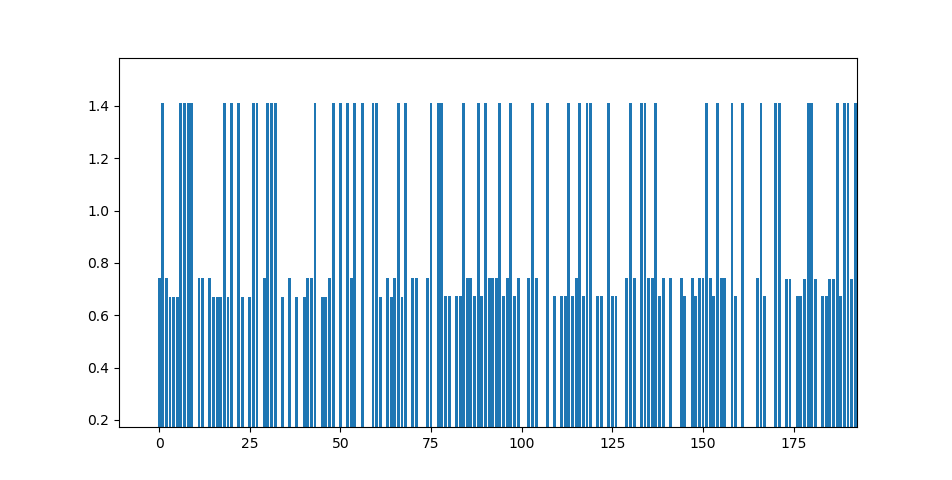

<BarContainer object of 1000 artists>

In [401]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.bar(np.arange(0, 1000), wrapper_1.r_buffer.T.flatten())

In this example r is sqrt(2) or 1/sqrt(2) or 0. Need to scale to -1, 0 and 1 > (r - 0.7ish)/0.7ish

In [402]:
wrapper_1.r_buffer.T.flatten()

array([0.74138513, 1.41246624, 0.74135954, 0.6711108 , 0.67110232,
       0.67108297, 1.41246382, 1.41246283, 1.41246224, 1.41246204,
       0.        , 0.7414037 , 0.74139825, 0.        , 0.74137531,
       0.67109198, 0.67108213, 0.67106147, 1.41246166, 0.67101864,
       1.41245703, 0.        , 1.41245467, 0.67095077, 0.        ,
       0.67091259, 1.41244715, 1.41244571, 0.        , 0.74158156,
       1.41244402, 1.41244413, 1.41244462, 0.        , 0.67087788,
       0.        , 0.74155521, 0.        , 0.67090763, 0.        ,
       0.67091351, 0.74153727, 0.7415381 , 1.41244915, 0.        ,
       0.67092143, 0.67090843, 0.7415508 , 1.41244682, 0.        ,
       1.41244709, 0.        , 1.41244932, 0.74152119, 1.41245229,
       0.        , 1.41245702, 0.        , 0.        , 1.41246748,
       1.41247153, 0.67117967, 0.        , 0.7412303 , 0.67127391,
       0.74118835, 1.41248795, 0.67133771, 1.41249096, 0.        ,
       0.74109272, 0.74107112, 0.        , 0.        , 0.74098

In [403]:
wrapper_2.r_buffer.T.flatten()

array([-1.41418054,  0.        ,  0.        ,  0.        ,  0.        ,
        1.4141805 ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.70225181, -0.7119315 ,  0.        , -0.71193511,
        0.        ,  1.41418035,  0.70224317,  0.        ,  0.        ,
        0.        ,  0.        ,  0.7119399 ,  1.4141803 ,  0.        ,
        1.41418029,  0.        ,  0.        ,  0.        , -0.70223783,
        0.        ,  0.        ,  0.        ,  0.        ,  1.41418022,
        0.        , -1.41418019,  0.        ,  1.41418018,  0.        ,
        0.        , -1.41418014, -0.71195426,  0.        ,  0.        ,
        0.70222311,  0.70222192,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -1.41417997,  0.71196371,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.70221049,  0.        , -1.41417986,  0.        ,
       -0.7119751 ,  0.        ,  0.70220276,  0.        ,  0.  

For wrapper_2 we have -sqrt(2), -1/sqrt(2), 0, sqrt(2) and +sqrt(2). This suggests probabilities - but do we need to scale first?

Also note the increase in 0s.

**What happens when we reconstruct with binary signals and not the values above?** We would need to apply the same scaling to the eigenvector.

In [407]:
print(wrapper_1.vpu.pi.eigenvector, wrapper_1.vpu.pi.eigenvalue, wrapper_1.vpu.cu.mean, sep="\n", end="\n\n")
print(np.dot(wrapper_1.vpu.pi.eigenvector, np.sqrt(wrapper_1.vpu.pi.eigenvalue))+wrapper_1.vpu.cu.mean)

[[-0.73905181]
 [ 0.67364859]]
[[0.25114336]]
[[-0.52520342]
 [ 0.53223693]]

[[-0.89557336]
 [ 0.86983057]]


In [421]:
print(np.dot(wrapper_1.vpu.pi.eigenvector, np.sqrt(wrapper_1.vpu.pi.eigenvalue)))

[[-0.37036994]
 [ 0.33759364]]


Is the "feature" here then [-1, 1] and we need to scale and add the mean to get the feature (or then feature / feature.max?).

In [428]:
print(wrapper_1.vpu.pi.eigenvector, np.abs(wrapper_1.vpu.pi.eigenvector).max())

[[-0.73905181]
 [ 0.67364859]] 0.7390518071517785


In [429]:
wrapper_1.vpu.pi.eigenvector / np.abs(wrapper_1.vpu.pi.eigenvector).max()

array([[-1.        ],
       [ 0.91150388]])

In [430]:
wrapper_2.vpu.pi.eigenvector / np.abs(wrapper_2.vpu.pi.eigenvector).max()

array([[0.98442181],
       [1.        ]])

**Divide by the largest value in the eigenvector then use the result as a probability?**

We only need to apply the PBT on the output.

**What about normalising the residual?**

The maximum distance in the space is 2 - -1 to 1. There is thus the chance for binary overflow -1 - (-1).

So the plan is:
* We normalise the eigenvector by dividing by the max entry (of the abs).
* We apply normalising and PBT to the r output.
* We normalise the residual (at the switch).

It would be good to do this and see if we get similar results to the test above.

In [408]:
print(wrapper_2.vpu.pi.eigenvector, wrapper_2.vpu.pi.eigenvalue, wrapper_2.vpu.cu.mean, sep="\n", end="\n\n")
print(np.dot(wrapper_2.vpu.pi.eigenvector, np.sqrt(wrapper_2.vpu.pi.eigenvalue))+wrapper_2.vpu.cu.mean)

[[0.70153421]
 [0.71263578]]
[[23.9485467]]
[[0.85455149]
 [1.44845634]]

[[4.28766715]
 [4.93590004]]


When scaled does this relate to the Hadamard matrix - [-1, 1] and [1, 1]?

The variations from 1 indicate the patterns in the input (they are based on a data_in of [60, 190]).

In [409]:
 mean = np.asarray([128,128]).reshape(-1, 1); print(mean)

[[128]
 [128]]


In [411]:
ternary_input.dtype

dtype('int64')

In [412]:
pred.dtype; print(pred)

[[0.]
 [0.]]


In [413]:
residual.dtype; print(residual)

[[0]
 [0]]


In [414]:
np.asarray([[0,  1]])-np.asarray([[-0.,  1.]])

array([[0., 0.]])

In [415]:
wrapper_1.residual_buffer.max()

1.0

In [416]:
wrapper_1.residual_buffer.min()

-1.0

Is the accuracy associated with the lack of the -2 or 2 residuals? These tend to make it go haywire.

Do we clamp or normalise and PBT?

In [417]:
print(f"Max wrapper 2 residual: {wrapper_2.residual_buffer.max()}; min wrapper 2 residual: {wrapper_2.residual_buffer.min()}")

Max wrapper 2 residual: 1.0; min wrapper 2 residual: -1.0


In [418]:
print(vpu.cu.mean)

[[-0.38986101]
 [ 0.44890511]]


Because we have a static value the CU mean is biased based on the static value. So we can ignore here - in real life we have variation so this should tend to 0 > need to check. If it is not 0 in real like we would need to constantly adapt such that it is 0.

In [419]:
print(np.sqrt(vpu.pi.eigenvalue))

[[0.5468012]]


In [434]:
from src.tests.vpu_wrapper import VPUWrapper

"""Use the VPU Wrapper to test advanced function."""
# Initialise two VPUs and wrappers
data_in = np.random.randint(255, size=(2, 1))
mean = np.asarray([128, 128]).reshape(-1, 1)
vpu_1 = VPU(2)
vpu_2 = VPU(2)
wrapper_1 = VPUWrapper(vpu_1)
wrapper_2 = VPUWrapper(vpu_2)
for _ in range(0, 1000):
    # First VPU
    ternary_input = signal_pre_processor(data_in, mean)
    _, _, residual = wrapper_1.iterate(ternary_input)
    # Second VPU
    _ = wrapper_2.iterate(residual)
est = (wrapper_1.pred_estimate*mean+mean)+(wrapper_2.pred_estimate*mean)
assert np.allclose(data_in, est, rtol=0.10, atol=10)
print(data_in, est)

[[190]
 [ 56]] [[192.59513639]
 [ 60.24752672]]
